# **Importing Required Libraries**


In [12]:
import pickle
import sklearn
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import pandas as pd

# **Loading the Required Datasets**


In [13]:
# Load datasets for Train and testing
with open('train.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('test.pkl', 'rb') as f:
    test_data = pickle.load(f)

# Randomizing training dataset
random.shuffle(train_data)

# Printing shapes of the datasets
print(train_data.shape)
print(test_data.shape)



(8000, 2)
(80, 2)


# **Sorting and Creating Test and Train Data**


### We sort the test data according to the x-values in order to get a uniform curve for increasing values.




In [14]:
#[ : , 0 ] means (more or less) [ first_row:last_row , column_0 ]. If you have a 2-dimensional list/matrix/array, this notation will give you all the values in column 0 (from all rows).

#sorting test_data 
test_data = sorted(test_data, key=lambda x: x[0])
#The above returns a list of tuples, where each tuple is a row of the data. That is why we need to convert it into an numpy array.
test_data = np.array(test_data)

# Loading training data and testing data for x,y  
x_train = train_data[:,0]
y_train = train_data[:,1]

x_test = test_data[:,0]
y_test = test_data[:,1]

# **Plotting The Data**

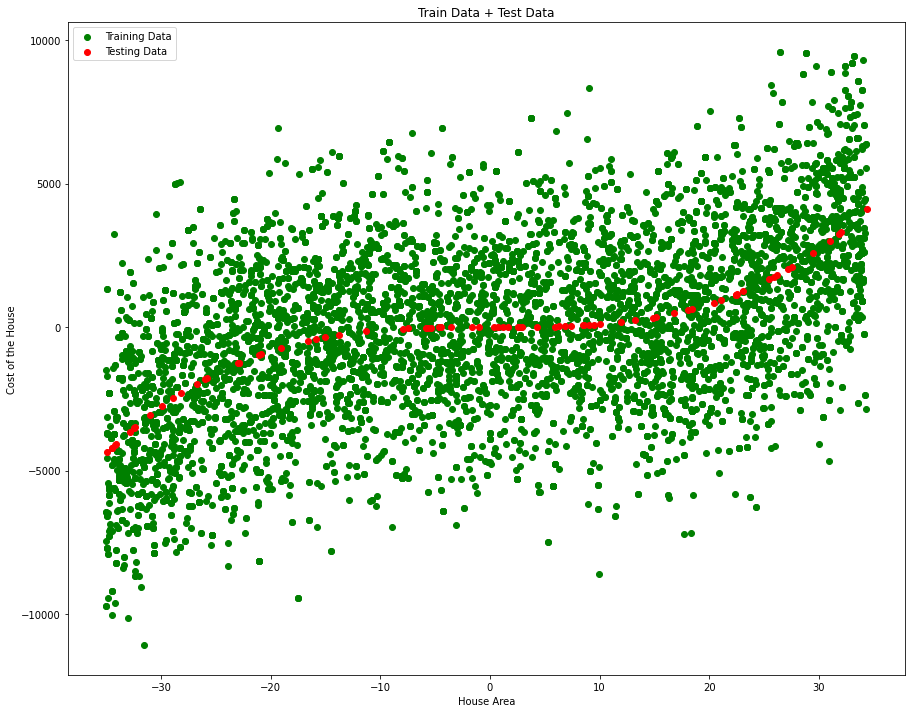

In [15]:
# Plotting training data and testing data accordingly
plt.figure(figsize=(15,12))
plt.scatter(x_train,y_train,label="Training Data",color ="g")
plt.scatter(x_test,y_test,label="Testing Data",color ="r")
plt.xlabel('House Area')
plt.ylabel('Cost of the House')
plt.legend()
plt.title("Train Data + Test Data")
plt.show()

# **Splitting the Training Data** 

In [16]:
#Splitting an array into equal parts (smaller datasets)
def split_array(array, parts):
    length = len(array)
    return [array[i * length // parts: (i + 1) * length // parts] for i in range(parts)]
x_train_divided = split_array(x_train, 16)
y_train_divided = split_array(y_train, 16)
## OR u can use np.array_split

# **MAIN CODE**

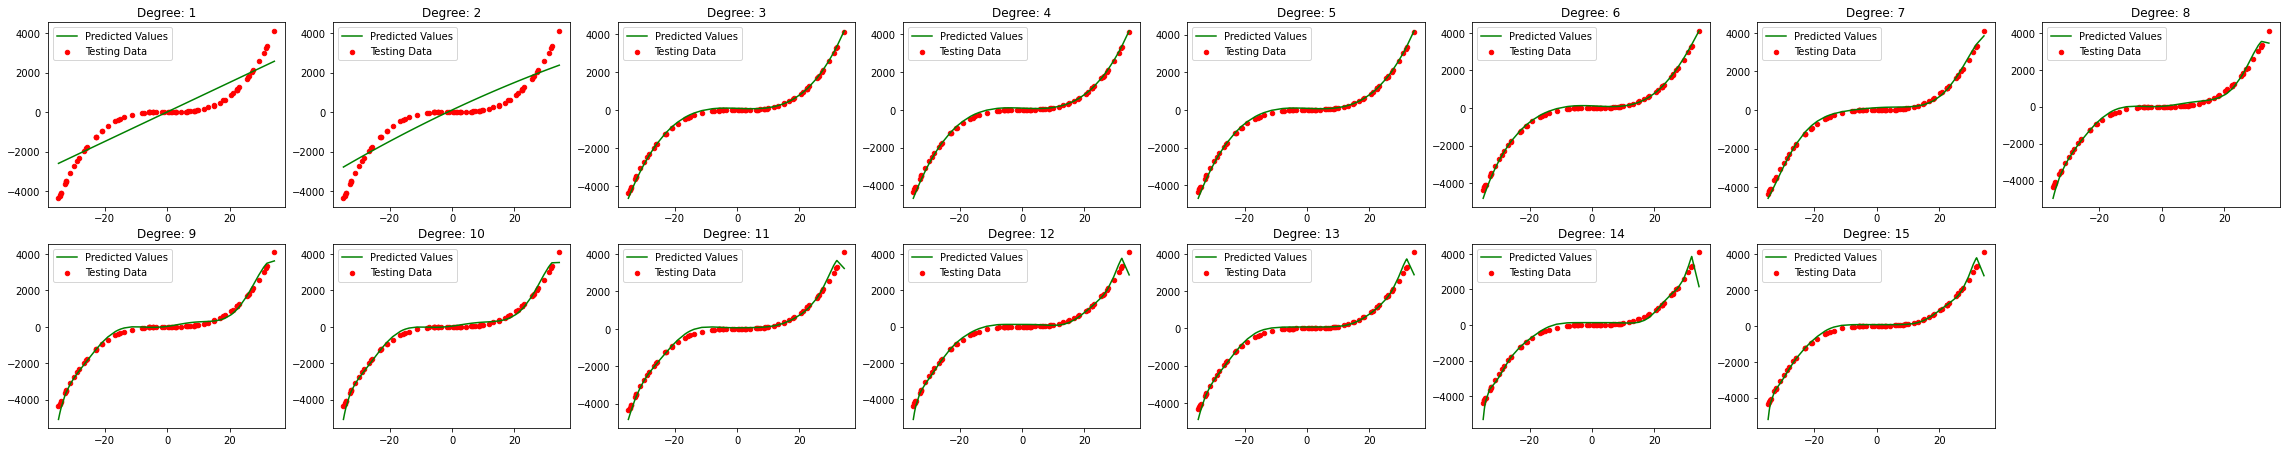

In [17]:
# Initializing a constant figsize workspace for the plotted diagrams
plt.figure(figsize=(40, 40))
# Function to plot the actual vs predicted graph for a single degree
def plotter(polynomial_degree, predicted_vals):
    # Plotting the graphs for each degree at a time
    plt.subplot(10, 8, polynomial_degree)
    plt.title("Degree: " + str(polynomial_degree))
    # Plotting predicted values vs actual values
    plt.scatter(x_test, y_test, label="Testing Data", color="r", s=20)
    plt.plot(x_test, predicted_vals, label="Predicted Values", color="g")
    plt.legend()


# Total array
y_preds_total = []
#Initializing arrays
no_of_models = 15
bias = np.zeros(no_of_models)  # Bias
bias_sq = np.zeros(no_of_models)  # Bias Square
variance = np.zeros(no_of_models)  # Variance
mse = np.zeros(no_of_models)  # Mean Squared Error
ire = np.zeros(no_of_models)  # Irreducible Errors
no_of_datasets=16
bias_sq_per_model = np.zeros((no_of_models, no_of_datasets))
variance_per_model = np.zeros((no_of_models, no_of_datasets))
mse_per_model = np.zeros((no_of_models, no_of_datasets))
ire_per_model = np.zeros((no_of_models, no_of_datasets))

# Loop to calculate required values for each degree and each dataset
# Necessity: 2 for loops
for polynomial_degree in range(1, 16):
    polynomial_eq = PolynomialFeatures(polynomial_degree)
    # Generating Zero array for all the predicted outcomes run on the testing data
    x_val = 16
    y_val = 80
    y_pred = np.zeros((x_val, y_val))

    segment = 0
    while segment < 16:
        # Calling each dataset
        X = x_train_divided[segment]
        # Transforming values into 2D arrays single 1D arrays dont work
        X = polynomial_eq.fit_transform(X.reshape(-1, 1))
        Y = y_train_divided[segment]

        # Regression Model Fitting
        reg_model = linear_model.LinearRegression()
        reg_model.fit(X, Y)
        # print('intercept:', reg_model.intercept_)
        # print('slope:', reg_model.coef_) 

        # Transforming values into 2D arrays single 1D arrays dont work
        x_test_temp = polynomial_eq.fit_transform(x_test.reshape(-1, 1))
        # Predicting on the test set
        y_pred_temp = reg_model.predict(x_test_temp)
        y_pred[segment] = y_pred_temp
        # calculating bias, variance, mse and ire for the segment
        bias_sq_per_model[polynomial_degree-1][segment] = np.mean(np.square(np.subtract(np.mean(y_pred_temp), y_test)))
        variance_per_model[polynomial_degree -1][segment] = np.mean(np.square(np.subtract(y_pred_temp, np.mean(y_pred_temp))))
        # variance_per_model[polynomial_degree -1][segment] = np.var(y_pred_temp)
        mse_per_model[polynomial_degree -1][segment] = np.mean(np.square(np.subtract(y_pred_temp, y_test)))
        ire_per_model[polynomial_degree-1][segment] = mse_per_model[polynomial_degree-1][segment] - bias_sq_per_model[polynomial_degree-1][segment]-variance_per_model[polynomial_degree-1][segment]

        segment += 1

    # Appending totally
    y_preds_total.append(y_pred)

    # Calculating mean across the columns for y_pred. y_pred is of size (16,80)
    # We reduce the above array into (1,80) where 16 -> 1 cause of finding mean across the columns
    y_pred_mean = np.mean(y_pred, axis=0)

    # Plotting function called here
    plotter(polynomial_degree, y_pred_mean)
    # Calculating bias, variance, mse and ire
    # bias[polynomial_degree-1] = (np.mean(y_pred_mean) - np.mean((y_test)))
    bias[polynomial_degree-1] = np.mean(np.subtract(y_pred_mean, y_test))
    # Bias Square
    bias_sq[polynomial_degree -1] = (np.mean(np.square(np.subtract(y_pred_mean, y_test))))
    # Variance
    # variance[polynomial_degree-1] = np.var(y_pred_mean) # Cant use it
    # variance[polynomial_degree-1] = (((y_pred - y_pred_mean)**2).mean(axis=0).mean())
    variance[polynomial_degree -1] = np.mean(np.mean(np.square(np.subtract(y_pred, y_pred_mean)), axis=0))
    # calculating mse
    # mse[polynomial_degree-1] = (((y_pred - y_test)**2).mean(axis=0).mean())
    mse[polynomial_degree -1] = np.mean(np.mean(np.square(np.subtract(y_pred, y_test)), axis=0))
    # calculating ire
    ire[polynomial_degree-1] = mse[polynomial_degree-1] - bias_sq[polynomial_degree-1]-variance[polynomial_degree-1]

plt.show()

# **Tabulating the Required Values**

In [18]:
# Tabulating degree,bias,variance using library pandas and storing it as a csv file
bias_var = pd.DataFrame({'DEGREE':[i for i in range(1,16)], 'BIAS':bias, 'VARIANCE':variance})
# bias_var.to_csv('deg-bias-var.csv')
bias_var

,DEGREE,BIAS,VARIANCE
0,1,184.102687,41513.456026
1,2,180.599784,67360.657763
2,3,7.769868,98115.987710
3,4,5.838310,125508.013871
4,5,5.143584,135011.434323
5,6,1.856187,164904.478891
6,7,6.854778,183964.460187
7,8,-16.317939,204415.648527
8,9,-15.773424,216296.358208
9,10,-14.420520,226378.378138


In [19]:
# Tabulating degree,ire using library pandas and storing it as a csv file
deg_ire = pd.DataFrame({'DEGREE':[i for i in range(1,16)],'IRE':ire})
# deg_ire.to_csv('deg-ire.csv')
deg_ire

,DEGREE,IRE
0,1,-7.275958e-12
1,2,-4.365575e-11
2,3,2.910383e-11
3,4,-2.910383e-11
4,5,0.000000e+00
5,6,2.910383e-11
6,7,2.910383e-11
7,8,0.000000e+00
8,9,-2.910383e-11
9,10,0.000000e+00


In [20]:
# Tabulating degree along with other fields using library pandas 
all = pd.DataFrame({'DEGREE':[i for i in range(1,16)], 'BIAS':bias, 'VARIANCE':variance, 'MSE':mse, 'IRE':ire})
all

,DEGREE,BIAS,VARIANCE,MSE,IRE
0,1,184.102687,41513.456026,538137.614905,-7.275958e-12
1,2,180.599784,67360.657763,534528.372651,-4.365575e-11
2,3,7.769868,98115.987710,109592.833430,2.910383e-11
3,4,5.838310,125508.013871,138962.422045,-2.910383e-11
4,5,5.143584,135011.434323,148138.020221,0.000000e+00
5,6,1.856187,164904.478891,182949.350877,2.910383e-11
6,7,6.854778,183964.460187,202261.819179,2.910383e-11
7,8,-16.317939,204415.648527,239912.277551,0.000000e+00
8,9,-15.773424,216296.358208,254648.552435,-2.910383e-11
9,10,-14.420520,226378.378138,264185.810372,0.000000e+00


# **Plotting Graphs Indivisually**

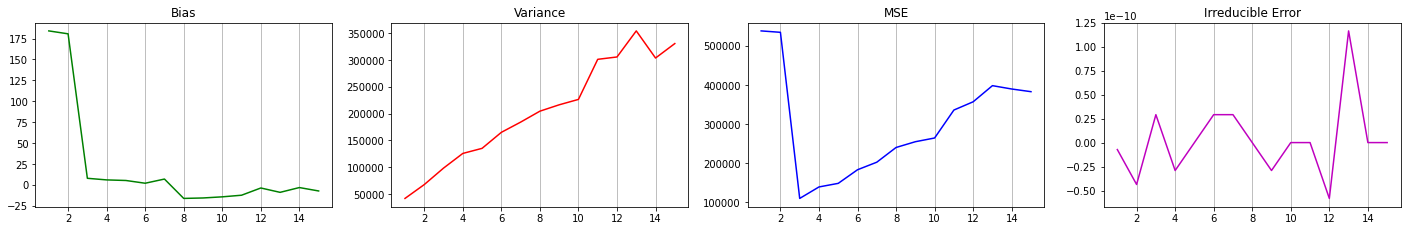

In [21]:
# Plotting all the 
plt.figure(figsize=(50, 40))
plt.subplot(10, 8, 1)
plt.grid(axis="x")
plt.title("Bias")
plt.plot([i for i in range(1,16)], bias, color="g")
plt.subplot(10, 8, 2)
plt.grid(axis="x")
plt.title("Variance")
plt.plot([i for i in range(1,16)], variance, color="r")
plt.subplot(10, 8, 3)
plt.grid(axis="x")
plt.title("MSE")
plt.plot([i for i in range(1,16)], mse, color="b")
plt.subplot(10, 8, 4)
plt.grid(axis="x")
plt.title("Irreducible Error")
plt.plot([i for i in range(1,16)], ire, color="m")

# **Plotting Bias^2 vs Variance**

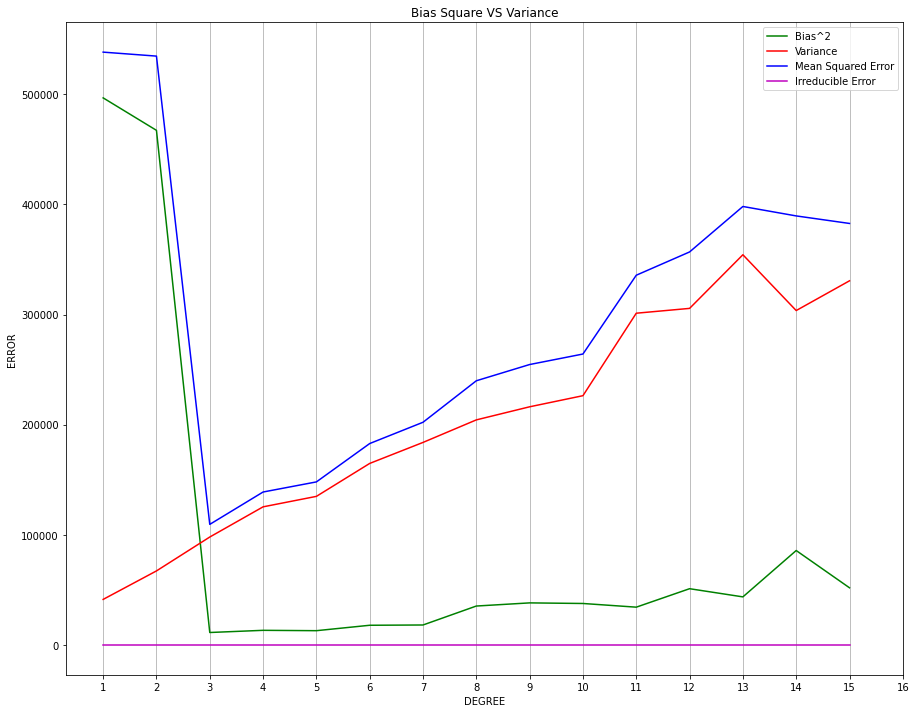

In [22]:
# Plotting training data and testing data accordingly
plt.figure(figsize=(15,12))
plt.plot([i for i in range(1,16)],bias_sq,label="Bias^2",color ="g")
plt.plot([i for i in range(1,16)],variance,label="Variance",color ="r")
plt.plot([i for i in range(1,16)],mse,label="Mean Squared Error",color ="b")
plt.plot([i for i in range(1,16)],ire,label="Irreducible Error",color ="m")
plt.xlabel('DEGREE')
plt.ylabel('ERROR')
plt.xticks(np.arange(1,17,1))
plt.grid(axis="x")
plt.legend()
plt.title("Bias Square VS Variance")
plt.show()